**spring = march, april, may**

**summer = june, july, august**

juneteenth (only in 2021)

july 4th

august has no holidays 

**fall = september, october, november**

**winter = december, january, februrary**

https://www.mikulskibartosz.name/time-in-machine-learning/



In [27]:
import tensorflow 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow import keras
from google.colab import drive
import os
import random
import math

drive.mount('/content/drive/', force_remount=True)
pd.options.mode.chained_assignment = None

Mounted at /content/drive/


# Functions

In [28]:
#purpose: scale the values of data points to be between 0 -> 1
#input: df = dataframe
#output: df = scaled df, allScalers = scalers for all variables

def scaleAllData(df, skip = 'is_weekend'):
    allScalers = []
    for column in df.columns:
      scaler = MinMaxScaler(feature_range=(0,1))
      df1 = df[column]
      df[column] = scaler.fit_transform(np.array(df1.values.reshape(-1, 1)))
      allScalers.append(scaler)
    return df, allScalers

In [29]:
#purpose: split data into the inputs and output prediction values
#input: df = dataframe, predictColPos = position of the var that you want to predict, window_size = timesteps, default is 1
#output: X = input data, y = what you want to predict data

def df_to_X_y(df, predictColPos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][predictColPos] 
        y.append(label)
    return np.array(X), np.array(y)

In [30]:
#purpose: make df; meaning it has all the weather var values scaled, the is weekend/weekday split, and megawatts
#inputs: df = dataframe, cols = the columns that we should have as mentioned above, directory = where to save scalers to, beg = position of df to start from, end = position of df to end at
#outputs: prepared df

# select df for specific season; I am choosing summer
def prepareDf(df, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg = 0, end = -1):
  df = df.iloc[beg:end, :]
  df['date'] = pd.to_datetime(df['date'], format='%m-%dT%H:%M:%S')
  df['date']= df["date"].map(lambda x: x.replace(year=2019))
  df.index = df['date']
  
  df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
  day = 60 * 60 * 24 #60 s in a min, 60 min in an hour, 24 hours in a day
  month = numDaysInMonth * 60 * day #num seconds in a month of AUGUST
  df['Day sin'] = np.sin(df['Seconds']*2*(np.pi/day))
  df['Day cos'] = np.cos(df['Seconds']*2*(np.pi/day))
  df['Month sin'] = np.sin(df['Seconds']*2*(np.pi/month))
  df['Month cos'] = np.cos(df['Seconds']*2*(np.pi/month))
  
  # starting from 06-01 which is a Sunday in 2019
  # dates are from 0 - 6
  # 0 1 2 3 4 5 6
  # M T W T F S S
  df['date'] = pd.to_datetime(df.date)
  df['day_of_week'] = df.date.dt.weekday
  # I want Sat/Sun to be treated the same, because they are both a weekend 
  df['is_weekend'] = df['day_of_week'].isin([5, 6])
  df['is_weekend'] = df['is_weekend'].astype(int)
  df.drop('date', axis=1, inplace=True)
  df.drop('day_of_week', axis=1, inplace=True)  

  df = df[cols_rearranged]

  #scaling and saving scalers
  return df

In [31]:
#purpose: generate a energy consumption model 
#input: df=dataframe, numEpochs = epochs for model training, baseLSTM_Directory = directory for LSTM, location = place sf/sac/sd/etc.
#output: rmse = rmse value, model = the model that resulted in that rmse value

def energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size):
    megawattsPos = len(df.columns) - 1
    X, y = df_to_X_y(df, megawattsPos, window_size)

    #############################################train and test #########################################################
    #456 data points 456/24 = 20 days, weekends are excluded (2019)
    #each data point is 24 
    # 80% data = day 0-15 is 16 days -> 360
    # 20% data = day 16-19 is 4 days -> 96

    allIndex = []
    for i in range(0, len(X), window_size): #get the indices for days in the month
      allIndex.append(i)

    random.shuffle(allIndex) #shuffle the indices of the day
    train_size =  round(len(X)/window_size * 0.8)* window_size

    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    ############################################# create model #########################################################
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
    model.add(Dense(32, 'relu')) #hidden layer 1
    model.add(Dense(32, 'relu')) #hidden layer 2
    model.add(Dense(1, 'linear')) #output layer
    
    storeModel = baseLSTM_Directory + 'model' + location +'/'
    
    cp = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    model.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = numEpochs, callbacks = [cp])

    ######################################### predictions and rmse ######################################################
    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals':y_train})
    rmse = mean_squared_error(train_predictions, y_train, squared=False)
    print("RMSE value: ", rmse)
    return rmse, model, allIndex

In [32]:
#purpose: make the final future energy consumption predictions for future hours
#input: bestEnergyConsumptionModel = best model to do prediction, data = prev day so that we can make future predictions, howManyFutureHours = how many hours to predict, window_size = timesteps, numVarInputs = number of variables for the model (energy consumption, weather data vars)
#output: future energy consumption
# futurePredictions_EC(bestEnergyConsumptionModel, df2021, howManyFutureHours, window_size, numVarInputs)
def futurePredictions_EC(bestEnergyConsumptionModel, dataForPrediction, howManyFutureHours, window_size, numVarInputs):
    future_outputs=[]
    i=0
    while(i<howManyFutureHours): #for the next thirty hours
      x_input = np.array(dataForPrediction.iloc[i:window_size+i, :])
      # print("i : ", i)
      # print('x_input: ', x_input)
      # print(x_input.shape)
      x_input = x_input.reshape(1, window_size, numVarInputs)
      yhat = bestEnergyConsumptionModel.predict(x_input, verbose=0)#.flatten()
      # print('future data: ', yhat[0])
      future_outputs.append(yhat[0][0])
      i=i+1

    return future_outputs

In [33]:
def printMonth_august(date_2021, dayInAugust):
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  
  dates2019 = ['20190801','20190802','20190803','20190804','20190805','20190806','20190807','20190808','20190809','20190810','20190811','20190812',
               '20190813','20190814','20190815','20190816','20190817','20190818','20190819','20190820','20190821','20190822','20190823',
               '20190824','20190825','20190826','20190827','20190828','20190829','20190830','20190831']
  dates2020 = ['20200801','20200802','20200803','20200804','20200805','20200806','20200807','20200808','20200809','20200810','20200811','20200812',
               '20200813','20200814','20200815','20200816','20200817','20200818','20200819','20200820','20200821','20200822','20200823',
               '20200824','20200825','20200826','20200827','20200828','20200829','20200830','20200831']
  dates2021 = ['20210801','20210802','20210803','20210804','20210805','20210806','20210807','20210808','20210809','20210810','20210811','20210812',
               '20210813','20210814','20210815','20210816','20210817','20210818','20210819','20210820','20210821','20210822','20210823','20210824',
               '20210825','20210826','20210827','20210828','20210829','20210830','20210831']
  august = ['08-01','08-02','08-03','08-04','08-05','08-06','08-07','08-08','08-09','08-10','08-11','08-12','08-13','08-14','08-15','08-16',
          '08-17','08-18','08-19','08-20','08-21','08-22','08-23','08-24','08-25','08-26','08-27','08-28','08-29','08-30','08-31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  rms2019_2020 = 0
  rms2019_2021 = 0
  rms2020_2021 = 0

  read2021 = pathToData + beg + date_2021 + end
  df2021 = pd.read_csv(read2021)
 
  return df2021['Megawatts']


In [34]:
def just_energyDemand(date_2019, date_2020, date_2021, august_date):
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/' 
  
  dates2019 = ['20190801','20190802','20190803','20190804','20190805','20190806','20190807','20190808','20190809','20190810','20190811','20190812',
               '20190813','20190814','20190815','20190816','20190817','20190818','20190819','20190820','20190821','20190822','20190823',
               '20190824','20190825','20190826','20190827','20190828','20190829','20190830','20190831']
  dates2020 = ['20200801','20200802','20200803','20200804','20200805','20200806','20200807','20200808','20200809','20200810','20200811','20200812',
               '20200813','20200814','20200815','20200816','20200817','20200818','20200819','20200820','20200821','20200822','20200823',
               '20200824','20200825','20200826','20200827','20200828','20200829','20200830','20200831']
  dates2021 = ['20210801','20210802','20210803','20210804','20210805','20210806','20210807','20210808','20210809','20210810','20210811','20210812',
               '20210813','20210814','20210815','20210816','20210817','20210818','20210819','20210820','20210821','20210822','20210823','20210824',
               '20210825','20210826','20210827','20210828','20210829','20210830','20210831']
  # august = ['08-01','08-02','08-03','08-04','08-05','08-06','08-07','08-08','08-09','08-10','08-11','08-12','08-13','08-14','08-15','08-16',
  #         '08-17','08-18','08-19','08-20','08-21','08-22','08-23','08-24','08-25','08-26','08-27','08-28','08-29','08-30','08-31']
  august = ['August 1','August 2','August 3','August 4','August 5','August 6','August 7','August 8','August 9','August 10','August 11','August 12',
          'August 13','August 14','August 15', 'August 16','August 17','August 18','August 19','August 20','August 21','August 22','August 23',
          'August 24','August 25','August 26','August 27', 'August 28','August 29','August 30','August 31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'
  rms2019_2020_2021 = 0
  rms2019_2021 = 0
  rms2020_2021 = 0

  read2019 = pathToData + beg + date_2019 + end
  read2020 = pathToData + beg + date_2020 + end
  read2021 = pathToData + beg + date_2021 + end
  
  df2019 = pd.read_csv(read2019)
  df2020 = pd.read_csv(read2020)
  df2021 = pd.read_csv(read2021)
  training = pd.concat([df2019, df2020], axis=1)
  training['Mean'] = training.mean(axis=1)

  rms2019_2020_2021 += round(mean_squared_error(training['Mean'], df2021['Megawatts'], squared=False), 2)

  plt.plot(training['Mean'], color = 'red', label = 'Training', linestyle="dotted")
  plt.plot(df2021['Megawatts'], color = 'lime', label = 'Testing')
  plt.xticks(xaxis)
  plt.xlabel('Hours')
  plt.ylabel('Megawatts')
  print(august[august_date])
  plt.suptitle(august[august_date] +" - Training vs. Testing Energy Demand", weight = "bold")
  plt.title('Offset:' + str(rms2019_2020_2021))
  plt.legend()
  plt.savefig(pathToSaveData+str(august[august_date])+'_groundTruth.jpg', bbox_inches = 'tight', dpi=150)
  plt.show()

In [35]:
def getEnergy_august(date_2019, date_2020, date_2021, august_date):
  pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/CAISO_NetDemand_Megawatts_google/' 
  pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/' 
  
  dates2019 = ['20190801','20190802','20190803','20190804','20190805','20190806','20190807','20190808','20190809','20190810','20190811','20190812',
               '20190813','20190814','20190815','20190816','20190817','20190818','20190819','20190820','20190821','20190822','20190823',
               '20190824','20190825','20190826','20190827','20190828','20190829','20190830','20190831']
  dates2020 = ['20200801','20200802','20200803','20200804','20200805','20200806','20200807','20200808','20200809','20200810','20200811','20200812',
               '20200813','20200814','20200815','20200816','20200817','20200818','20200819','20200820','20200821','20200822','20200823',
               '20200824','20200825','20200826','20200827','20200828','20200829','20200830','20200831']
  dates2021 = ['20210801','20210802','20210803','20210804','20210805','20210806','20210807','20210808','20210809','20210810','20210811','20210812',
               '20210813','20210814','20210815','20210816','20210817','20210818','20210819','20210820','20210821','20210822','20210823','20210824',
               '20210825','20210826','20210827','20210828','20210829','20210830','20210831']
  august = ['08-01','08-02','08-03','08-04','08-05','08-06','08-07','08-08','08-09','08-10','08-11','08-12','08-13','08-14','08-15','08-16',
          '08-17','08-18','08-19','08-20','08-21','08-22','08-23','08-24','08-25','08-26','08-27','08-28','08-29','08-30','08-31']
  
  xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
  beg = 'CAISO-netdemand-'
  end = '-Megawatts.csv'

  read2019 = pathToData + beg + date_2019 + end
  read2020 = pathToData + beg + date_2020 + end
  read2021 = pathToData + beg + date_2021 + end

  df2019 = pd.read_csv(read2019)
  df2020 = pd.read_csv(read2020)
  df2021 = pd.read_csv(read2021)
  training = pd.concat([df2019, df2020], axis=1)
  training['Mean'] = training.mean(axis=1)

  return training['Mean'], df2021['Megawatts'] #diff from training and diff from testing/2021 prediction data

In [36]:
def percentageOf(prediction, groundTruth):
  allVals = 0
  wholeDay = []
  for i in range(len(prediction)):
    # print("i is: ", str(i))
    # print("groundTruth: ", str(groundTruth[i]))
    # print("prediction: ", str(prediction[i]))
    oneDiff = abs(groundTruth[i] - prediction[i])/ (groundTruth[i])
    allVals+=oneDiff
    wholeDay.append(oneDiff)
    # print(oneDiff)

  return wholeDay, allVals/(len(prediction))

# Run

In [52]:
pathToData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2019_2020/'
dataFile = [f for f in listdir(pathToData) if isfile(join(pathToData, f))] 
for file in dataFile:
    print(file)
    # df = pd.read_csv(pathToDir + file)

print('-------')
#for now, I will only use SF data 
pos = 3
iteration = 0

fileRead = pathToData + dataFile[pos]
print('fileRead: ', fileRead)
df = pd.read_csv(fileRead)
df_sac = pd.read_csv(pathToData + dataFile[0])
df_sf = pd.read_csv(pathToData + dataFile[1])
df_sd = pd.read_csv(pathToData + dataFile[2])
df_la = pd.read_csv(pathToData + dataFile[3])
# 2021 data
pathToData1 = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2021/'
dataFile1 = [f for f in listdir(pathToData1) if isfile(join(pathToData1, f))] 
for file in dataFile1:
    print(file)
    # df = pd.read_csv(pathToDir + file)
 
fileRead1 = pathToData1 + dataFile1[pos]
print('fileRead: ', fileRead1)
df2021 = pd.read_csv(fileRead1)
df2021_sac = pd.read_csv(pathToData1 + dataFile1[0])
df2021_sf = pd.read_csv(pathToData1 + dataFile1[1])
df2021_sd = pd.read_csv(pathToData1 + dataFile1[2])
df2021_la = pd.read_csv(pathToData1 + dataFile1[3])

howManyFutureHours = 24
window_size = 72
numEpochs = 20
iters = 4

beg = 5088
end = 5832
numDaysInMonth = 31


baseLSTM_Directory = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/'
locArray = ['_SAC', '_SF', '_SD', '_LA']
location = locArray[pos]
print(location)
##### MAKE SURE YOU CHANGED ALL VARIABLES RELATED TO LOCATION ABOVE BEFORE RUNNING THIS CELL

SAC-yearAvg-NOAA-and-Megawatts.csv
SF-yearAvg-NOAA-and-Megawatts.csv
SD-yearAvg-NOAA-and-Megawatts.csv
LA-yearAvg-NOAA-and-Megawatts.csv
-------
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2019_2020/LA-yearAvg-NOAA-and-Megawatts.csv
SAC-NOAA-and-Megawatts.csv
SF-NOAA-and-Megawatts.csv
SD-NOAA-and-Megawatts.csv
LA-NOAA-and-Megawatts.csv
fileRead:  /content/drive/MyDrive/Fairness ML/FairnessML_git/Datasets/2021/LA-NOAA-and-Megawatts.csv
_LA


In [53]:
####sac
df_sac.columns[1:-1]
cols_rearranged = list(df_sac.columns[1:-1])
cols_rearranged.append('is_weekend')
cols_rearranged.append('Day sin')
cols_rearranged.append('Day cos')
cols_rearranged.append('Month sin')
cols_rearranged.append('Month cos')
cols_rearranged.append('AvgMegawatts2019-2020')

df_sac = prepareDf(df_sac, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_sac = df_sac[df_sac.is_weekend == 0] # only keeping weekday data
df_sac.drop('is_weekend', axis = 1, inplace =True)
df_sac, allScalers = scaleAllData(df_sac)

#### sf

cols_rearranged_sf = list(df_sf.columns[1:-1])
cols_rearranged_sf.append('is_weekend')

df_sf = prepareDf(df_sf, cols_rearranged_sf, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_sf = df_sf[df_sf.is_weekend == 0] # only keeping weekday data
df_sf.drop('is_weekend', axis = 1, inplace =True)

df_sf, discard = scaleAllData(df_sf)

####sd

cols_rearranged_sd = list(df_sd.columns[1:-1])
cols_rearranged_sd.append('is_weekend')

df_sd = prepareDf(df_sd, cols_rearranged_sd, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_sd = df_sd[df_sd.is_weekend == 0] # only keeping weekday data
df_sd.drop('is_weekend', axis = 1, inplace =True)

df_sd, discard = scaleAllData(df_sd)

####la

cols_rearranged_la = list(df_la.columns[1:-1])
cols_rearranged_la.append('is_weekend')

df_la = prepareDf(df_la, cols_rearranged_la, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df_la = df_la[df_la.is_weekend == 0] # only keeping weekday data
df_la.drop('is_weekend', axis = 1, inplace =True)

df_la, discard = scaleAllData(df_la)

df = pd.concat([df_sf, df_sd, df_la, df_sac], axis=1) # combine all weather variable data into one dataframe, df
# saveScalers(df, baseLSTM_Directory, location, allScalers) #saving scalers
julyFourth =[72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]
df.drop(df.index[julyFourth], inplace=True) # remove July 4th

rmse, bestEnergyConsumptionModel, allIndex = energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size)
# rmse, bestEnergyConsumptionModel, X, y = energyConsumptionModel(df, numEpochs, baseLSTM_Directory, location, window_size)

saveModelsDir = baseLSTM_Directory +'Best'+ location + '/'
bestEnergyConsumptionModel.save(saveModelsDir +'energyModel/', save_format = 'utf')

########################################## GET DATA FOR FUTURE PREDICTION #######################################################

####sac
df2021_sac.columns[1:-1]
cols_rearranged = list(df2021_sac.columns[1:-1])
cols_rearranged.append('is_weekend')
cols_rearranged.append('Day sin')
cols_rearranged.append('Day cos')
cols_rearranged.append('Month sin')
cols_rearranged.append('Month cos')
cols_rearranged.append('Megawatts_2021')

df2021_sac = prepareDf(df2021_sac, cols_rearranged, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_sac = df2021_sac[df2021_sac.is_weekend == 0] # only keeping weekday data
df2021_sac.drop('is_weekend', axis = 1, inplace =True)
df2021_sac, discard = scaleAllData(df2021_sac)

#### sf

cols_rearranged_sf = list(df2021_sf.columns[1:-1])
cols_rearranged_sf.append('is_weekend')

df2021_sf = prepareDf(df2021_sf, cols_rearranged_sf, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_sf = df2021_sf[df2021_sf.is_weekend == 0] # only keeping weekday data
df2021_sf.drop('is_weekend', axis = 1, inplace =True)

df2021_sf, discard = scaleAllData(df2021_sf)

####sd

cols_rearranged_sd = list(df2021_sd.columns[1:-1])
cols_rearranged_sd.append('is_weekend')

df2021_sd = prepareDf(df2021_sd, cols_rearranged_sd, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_sd = df2021_sd[df2021_sd.is_weekend == 0] # only keeping weekday data
df2021_sd.drop('is_weekend', axis = 1, inplace =True)

df2021_sd, discard = scaleAllData(df2021_sd)

####la

cols_rearranged_la = list(df2021_la.columns[1:-1])
cols_rearranged_la.append('is_weekend')

df2021_la = prepareDf(df2021_la, cols_rearranged_la, baseLSTM_Directory, location, numDaysInMonth, beg, end)
df2021_la = df2021_la[df2021_la.is_weekend == 0] # only keeping weekday data
df2021_la.drop('is_weekend', axis = 1, inplace =True)

df2021_la, discard = scaleAllData(df2021_la)

df2021 = pd.concat([df2021_sf, df2021_sd, df2021_la, df2021_sac], axis=1) # combine all weather variable data into one dataframe, df
df2021.drop(df2021.index[julyFourth], inplace=True) #removing July 4th
# # ########################################## FUTURE PREDICTION #######################################################
numVarInputs = len(df2021.columns)
# lastTwoDays = len(df2021) - 48
df2021_clean = df2021
df2021_clean.drop(df2021_clean.index[julyFourth], inplace=True) #removing July 4th


Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.0834 - root_mean_squared_error: 0.2888

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


12/12 [==============================] - 8s 559ms/step - loss: 0.0834 - root_mean_squared_error: 0.2888 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1186

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


12/12 [==============================] - 6s 510ms/step - loss: 0.0141 - root_mean_squared_error: 0.1186 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 3/20
12/12 [==============================] - 1s 47ms/step - loss: 0.0086 - root_mean_squared_error: 0.0930 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1224
Epoch 4/20
12/12 [==============================] - 1s 47ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 5/20
12/12 [==============================] - 1s 49ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 6/20
12/12 [==============================] - 1s 47ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 7/20
12/12 [==============================] - 1s 46ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0194 - val_root_mean_square

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


12/12 [==============================] - 6s 505ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857
Epoch 11/20
12/12 [==============================] - 1s 50ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 12/20
12/12 [==============================] - 1s 47ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 13/20
12/12 [==============================] - 1s 47ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1107
Epoch 14/20
12/12 [==============================] - 1s 48ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875
Epoch 15/20
12/12 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0491

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


12/12 [==============================] - 5s 454ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 16/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0460

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


12/12 [==============================] - 6s 504ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776
Epoch 17/20
11/12 [==========================>...] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0434

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


12/12 [==============================] - 5s 495ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707
Epoch 18/20
12/12 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0424

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/model_LA/assets


12/12 [==============================] - 5s 454ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 19/20
12/12 [==============================] - 1s 47ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 20/20
12/12 [==============================] - 1s 48ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
RMSE value:  0.057786521679238624


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/Best_LA/energyModel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/Best_LA/energyModel/assets


In [54]:
# four days of prediction
lastDay = len(df2021) - (24*4)
print(lastDay)

d1 = 456 # day 19, August 30
d2 = 240 # day 10
d3 = 72 # day 3
d4 = 192 # day 8

384


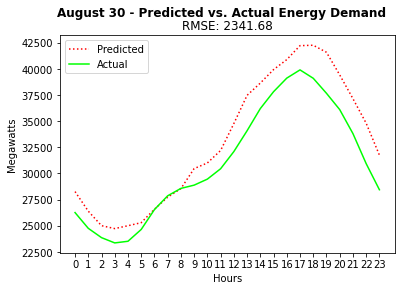

Percent error is:  [0.06404089]


In [55]:
########## DAY 1: August 30
date_2021 = '20210830'
dayInAugust = 29
augustRep1 = printMonth_august(date_2021, dayInAugust)

day1 = df2021_clean.iloc[d1-window_size:d1+window_size,:]
lst_output_1 = futurePredictions_EC(bestEnergyConsumptionModel, day1, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals_1 = megawattsScaler.inverse_transform(np.array(lst_output_1).reshape(-1,1))
predicted24Hours_1 = pd.DataFrame(predictedVals_1)

rmse_1 = round(mean_squared_error(augustRep1, predicted24Hours_1, squared=False), 2)

plt.plot(predicted24Hours_1, color = 'red', label = 'Predicted', linestyle = 'dotted')
plt.plot(augustRep1, color = 'lime', label ='Actual')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('August 30 - Predicted vs. Actual Energy Demand', weight='bold')
plt.title("RMSE: " + str(rmse_1))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/'
plt.savefig(pathToSaveData+'August30_predict.jpg', bbox_inches = 'tight', dpi=150)
plt.show()
vals, res = percentageOf(predictedVals_1, list(augustRep1))
print("Percent error is: ", str(res))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


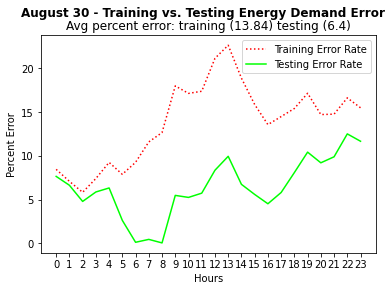

In [56]:
#August 30 ERROR
date_2019 = '20190830'
date_2020 = '20200830'
date_2021 = '20210830'
august_date = 29

training_ED1, testing_ED1 = getEnergy_august(date_2019, date_2020, date_2021, august_date)

training_error1, avg_training_error1 = percentageOf(predictedVals_1, training_ED1)
testing_error1, avg_testing_error1 = percentageOf(predictedVals_1, testing_ED1)
training_error1 = list(training_error1)
testing_error1 = list(testing_error1)
# in percentage, so mult by 100
for i in range(len(testing_error1)):
  testing_error1[i] *= 100
  training_error1[i] *= 100

# average percent error reformatted
avg_training_error1 = round(avg_training_error1.astype(float)[0] * 100, 2)
avg_testing_error1 = round(avg_testing_error1.astype(float)[0] * 100, 2)

plt.plot(training_error1, color = 'red', label = 'Training Error Rate', linestyle='dotted')
plt.plot(testing_error1, color = 'lime', label ='Testing Error Rate')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('August 30 - Training vs. Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "training (" + str(avg_training_error1) + ") testing ("+str(avg_testing_error1)+")")
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/'
plt.savefig(pathToSaveData+'August30_error.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


August 30


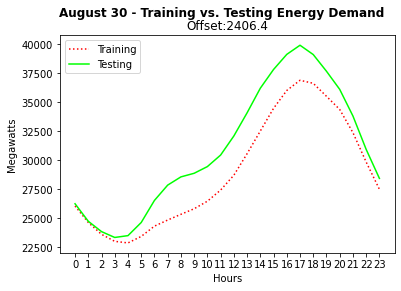

In [57]:
just_energyDemand(date_2019, date_2020, date_2021, august_date)

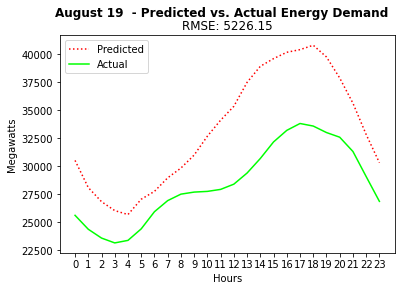

res is:  [0.16519111]


In [58]:
########## DAY 2: August 19
date_2021 = '20210819'
dayInAugust = 18

augustRep2 = printMonth_august(date_2021, dayInAugust)

day2 = df2021_clean.iloc[d2-window_size:d2+window_size,:]
lst_output_2 = futurePredictions_EC(bestEnergyConsumptionModel, day2, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals_2 = megawattsScaler.inverse_transform(np.array(lst_output_2).reshape(-1,1))
predicted24Hours_2 = pd.DataFrame(predictedVals_2)

rmse_2 = round(mean_squared_error(augustRep2, predicted24Hours_2, squared=False), 2)

plt.plot(predicted24Hours_2, color = 'red', label = 'Predicted', linestyle="dotted")
plt.plot(augustRep2, color = 'lime', label ='Actual')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('August 19  - Predicted vs. Actual Energy Demand', weight='bold')
plt.title("RMSE: " + str(rmse_2))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/'
plt.savefig(pathToSaveData+'August19_predict.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

allVals, res = percentageOf(predictedVals_2, list(augustRep2))
print("res is: ", res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


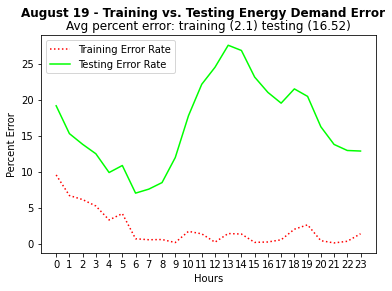

In [59]:
#August 19 ERROR
date_2019 = "20190819"
date_2020 = "20200819"
date_2021 = '20210819'
august_date = 18

training_ED2, testing_ED2 = getEnergy_august(date_2019, date_2020, date_2021, august_date)

training_error2, avg_training_error2 = percentageOf(predictedVals_2, training_ED2)
testing_error2, avg_testing_error2 = percentageOf(predictedVals_2, testing_ED2)
training_error2 = list(training_error2)
testing_error2 = list(testing_error2)
# in percentage, so mult by 100
for i in range(len(testing_error2)):
  testing_error2[i] *= 100
  training_error2[i] *= 100

# average percent error reformatted
avg_training_error2 = round(avg_training_error2.astype(float)[0] * 100, 2)
avg_testing_error2 = round(avg_testing_error2.astype(float)[0] * 100, 2)

plt.plot(training_error2, color = 'red', label = 'Training Error Rate', linestyle='dotted')
plt.plot(testing_error2, color = 'lime', label ='Testing Error Rate')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('August 19 - Training vs. Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "training (" + str(avg_training_error2) + ") testing ("+str(avg_testing_error2)+")")
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/'
plt.savefig(pathToSaveData+'August19_error.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


August 19


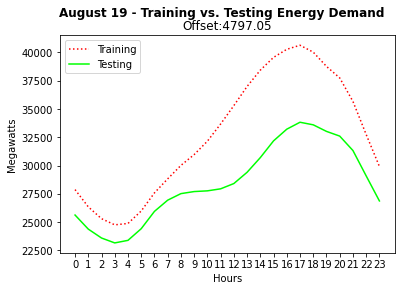

In [60]:
just_energyDemand(date_2019, date_2020, date_2021, august_date)

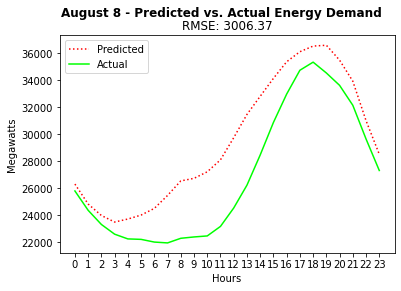

res is:  [0.10060417]


In [61]:
########## DAY 3: August 8
date_2021 = '20210808'
dayInAugust = 7
augustRep3 = printMonth_august(date_2021, dayInAugust)

day3 = df2021_clean.iloc[d3-window_size:d3+window_size,:]
lst_output_3 = futurePredictions_EC(bestEnergyConsumptionModel, day3, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals_3 = megawattsScaler.inverse_transform(np.array(lst_output_3).reshape(-1,1))
predicted24Hours_3 = pd.DataFrame(predictedVals_3)

rmse_3 = round(mean_squared_error(augustRep3, predicted24Hours_3, squared=False), 2)

plt.plot(predicted24Hours_3, color = 'red', label = 'Predicted', linestyle="dotted")
plt.plot(augustRep3, color = 'lime', label ='Actual')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('August 8 - Predicted vs. Actual Energy Demand', weight='bold')
plt.title("RMSE: " + str(rmse_3))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/'
plt.savefig(pathToSaveData+'August8_predict.jpg', bbox_inches = 'tight', dpi=150) 
plt.show()

vals, res = percentageOf(predictedVals_3, list(augustRep3))
print("res is: ", str(res))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


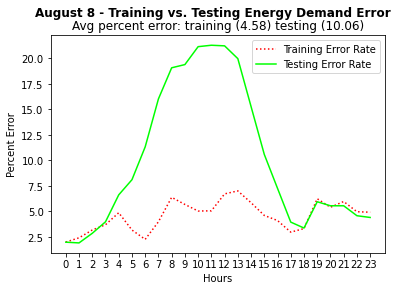

In [62]:
#day 21, July 30
date_2019 = "20190808"
date_2020 = "20200808"
date_2021 = "20210808"
august_date = 7

training_ED3, testing_ED3 = getEnergy_august(date_2019, date_2020, date_2021, august_date)

training_error3, avg_training_error3 = percentageOf(predictedVals_3, training_ED3)
testing_error3, avg_testing_error3 = percentageOf(predictedVals_3, testing_ED3)

training_error3 = list(training_error3)
testing_error3 = list(testing_error3)
# in percentage, so mult by 100
for i in range(len(testing_error3)):
  testing_error3[i] *= 100
  training_error3[i] *= 100

# average percent error reformatted
avg_training_error3 = round(avg_training_error3.astype(float)[0] * 100, 2)
avg_testing_error3 = round(avg_testing_error3.astype(float)[0] * 100, 2)

plt.plot(training_error3, color = 'red', label = 'Training Error Rate', linestyle='dotted')
plt.plot(testing_error3, color = 'lime', label ='Testing Error Rate')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('August 8 - Training vs. Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "training (" + str(avg_training_error3) + ") testing ("+str(avg_testing_error3)+")")
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/'
plt.savefig(pathToSaveData+'August8_error.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


August 8


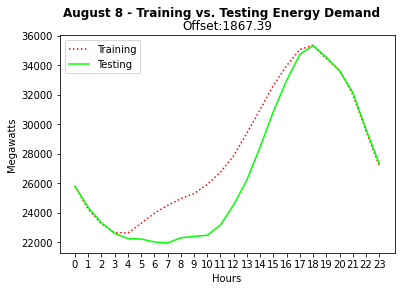

In [63]:
just_energyDemand(date_2019, date_2020, date_2021, august_date)

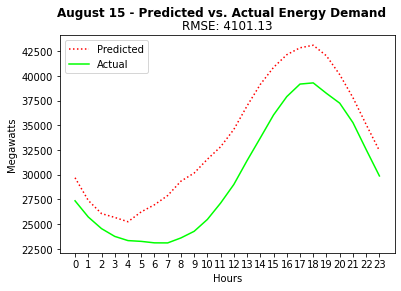

res is:  [0.13280083]


In [64]:
########## DAY 4: August 15
date_2021 = '20210815'
dayInAugust = 14 
augustRep4 = printMonth_august(date_2021, dayInAugust)

day4 = df2021_clean.iloc[d4-window_size:d4+window_size,:]
lst_output_4 = futurePredictions_EC(bestEnergyConsumptionModel, day4, howManyFutureHours, window_size, numVarInputs)

megawattsScaler = allScalers[len(allScalers)-1]

predictedVals_4 = megawattsScaler.inverse_transform(np.array(lst_output_4).reshape(-1,1))
predicted24Hours_4 = pd.DataFrame(predictedVals_4)

rmse_4 = round(mean_squared_error(augustRep4, predicted24Hours_4, squared=False), 2)

plt.plot(predicted24Hours_4, color = 'red',  label = 'Predicted', linestyle="dotted")
plt.plot(augustRep4, color = 'lime', label ='Actual')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.xlabel('Hours')
plt.ylabel('Megawatts')
plt.suptitle('August 15 - Predicted vs. Actual Energy Demand', weight='bold')
plt.title("RMSE: " + str(rmse_4))
plt.legend()
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/'
plt.savefig(pathToSaveData+'August15_predict.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

val, res = percentageOf(predictedVals_4, list(augustRep4))
print("res is: ", str(res))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


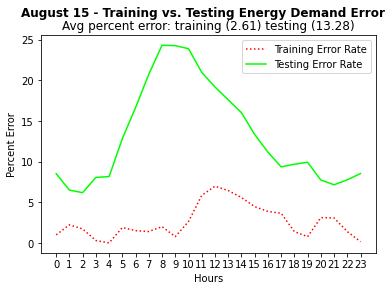

In [65]:
# day 22, July 31
date_2019 = "20190815"
date_2020 = "20200815"
date_2021 = "20210815"
august_date = 14

training_ED4, testing_ED4 = getEnergy_august(date_2019, date_2020, date_2021, august_date)

training_error4, avg_training_error4 = percentageOf(predictedVals_4, training_ED4)
testing_error4, avg_testing_error4 = percentageOf(predictedVals_4, testing_ED4)
training_error4 = list(training_error4)
testing_error4 = list(testing_error4)
# in percentage, so mult by 100
for i in range(len(testing_error4)):
  testing_error4[i] *= 100
  training_error4[i] *= 100

# average percent error reformatted
avg_training_error4 = round(avg_training_error4.astype(float)[0] * 100, 2)
avg_testing_error4 = round(avg_testing_error4.astype(float)[0] * 100, 2)

plt.plot(training_error4, color = 'red', label = 'Training Error Rate', linestyle='dotted')
plt.plot(testing_error4, color = 'lime', label ='Testing Error Rate')

xaxis =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
plt.xticks(xaxis)
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Percent Error')
plt.suptitle('August 15 - Training vs. Testing Energy Demand Error', weight='bold')
plt.title("Avg percent error: " + "training (" + str(avg_training_error4) + ") testing ("+str(avg_testing_error4)+")")
pathToSaveData = '/content/drive/MyDrive/Fairness ML/FairnessML_git/Experiment-5/all/'
plt.savefig(pathToSaveData+'August15_error.jpg', bbox_inches = 'tight', dpi=150)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


August 15


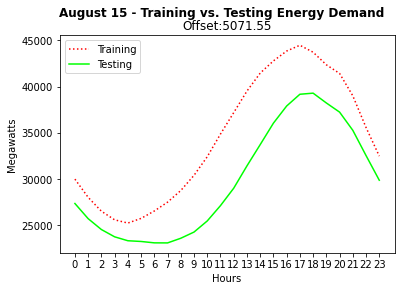

In [66]:
just_energyDemand(date_2019, date_2020, date_2021, august_date)